# 🌍 Qartezator: Yet another aerial image-to-map translator

## Environment setup

First you need to install qartezator from project root directory

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


## Setup Dataloaders

In [2]:
import torch
from PIL import Image

from qartezator.data.dataset import QartezatorDataset
from qartezator.data.datamodule import QartezatorDataModule
from qartezator.data.transforms import get_common_augmentations

In [3]:
root_path = './data/maps'
train_txt_path = './assets/train.txt'
val_txt_path = './assets/val.txt'
test_txt_path = './assets/test.txt'

In [4]:
ds = QartezatorDataset(
    root_path=root_path,
    split_file_path=train_txt_path,
    common_transform=get_common_augmentations(256)
)
sample_source_img, sample_target_img = ds[42]

In [5]:
sample_target_img.shape

(256, 256, 3)

In [6]:
sample_source_img

array([[[0.20392157, 0.20392157, 0.19607843],
        [0.30980392, 0.30980392, 0.30196078],
        [0.32941176, 0.32941176, 0.32156863],
        ...,
        [0.11764706, 0.15686275, 0.1254902 ],
        [0.11764706, 0.15686275, 0.1254902 ],
        [0.11372549, 0.14901961, 0.12941176]],

       [[0.22745098, 0.22745098, 0.21960784],
        [0.23921569, 0.23921569, 0.23137255],
        [0.30196078, 0.30196078, 0.29411765],
        ...,
        [0.11764706, 0.15686275, 0.1254902 ],
        [0.11764706, 0.15686275, 0.1254902 ],
        [0.11372549, 0.14901961, 0.12941176]],

       [[0.22745098, 0.22745098, 0.21960784],
        [0.17647059, 0.17647059, 0.16862745],
        [0.24705882, 0.24705882, 0.23921569],
        ...,
        [0.11764706, 0.15686275, 0.1254902 ],
        [0.11764706, 0.15686275, 0.1254902 ],
        [0.11372549, 0.14901961, 0.12941176]],

       ...,

       [[0.2       , 0.21176471, 0.17647059],
        [0.19215686, 0.20392157, 0.17647059],
        [0.18431373, 0

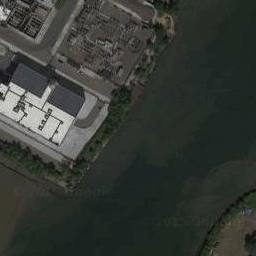

In [7]:
import numpy as np

Image.fromarray((sample_source_img * 255).astype(np.uint8))

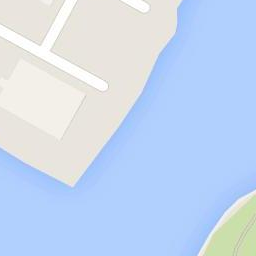

In [8]:
Image.fromarray((sample_target_img * 255).astype(np.uint8))

In [17]:
dm = QartezatorDataModule(
    root_path=root_path,
    train_txt_path=train_txt_path,
    val_txt_path=val_txt_path,
    test_txt_path=test_txt_path,
    input_size=256,
    train_batch_size=2
)
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

In [18]:
for batch in train_dataloader:
    source, target = batch
    print(f'Source batch shape: {source.shape}')
    print(f'Target batch shape: {target.shape}\n')
    break

Source batch shape: torch.Size([2, 3, 256, 256])
Target batch shape: torch.Size([2, 3, 256, 256])



In [10]:
len(train_dataloader.dataset)

2792

In [11]:
len(val_dataloader.dataset)

250

In [12]:
len(test_dataloader.dataset)

250

In [19]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import os
from glob import glob
from tqdm import trange
from itertools import chain

import torch.nn.parallel
import torchvision.utils as vutils
from torch.autograd import Variable
import itertools
import torchvision

# from data_loader import get_loader

In [20]:
class GeneratorCNN(nn.Module):
    def __init__(self, input_channel, output_channel, conv_dims = [32, 64, 128, 256], deconv_dims = [128, 64, 32]):
        super(GeneratorCNN, self).__init__()
        self.num_gpu = 1
        self.layers = []

        prev_dim = conv_dims[0]
        self.layers.append(nn.Conv2d(input_channel, prev_dim, 3, 1, 1, bias=False))
        self.layers.append(nn.BatchNorm2d(prev_dim))
        self.layers.append(nn.LeakyReLU(0.2, inplace=True))
        self.layers.append(nn.Conv2d(prev_dim, prev_dim, 3, 2, 1, bias=False))
        self.layers.append(nn.BatchNorm2d(prev_dim))
        self.layers.append(nn.LeakyReLU(0.2, inplace=True))

        for out_dim in conv_dims[1:]:
            self.layers.append(nn.Conv2d(prev_dim, prev_dim, 3, 1, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(prev_dim))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            self.layers.append(nn.Conv2d(prev_dim, out_dim, 3, 2, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(out_dim))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            prev_dim = out_dim

        for out_dim in deconv_dims:
            self.layers.append(nn.Conv2d(prev_dim, prev_dim, 3, 1, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(prev_dim))
            self.layers.append(nn.LeakyReLU(True))
            self.layers.append(nn.ConvTranspose2d(prev_dim, out_dim, 3, 2, 1, bias=False))
            self.layers.append(nn.BatchNorm2d(out_dim))
            self.layers.append(nn.LeakyReLU(True))
            prev_dim = out_dim

        self.layers.append(nn.ConvTranspose2d(prev_dim, prev_dim, 3, 2, 1, bias=False))
        self.layers.append(nn.BatchNorm2d(prev_dim))
        self.layers.append(nn.LeakyReLU())
        self.layers.append(nn.ConvTranspose2d(prev_dim, output_channel, 3, 2, 1, bias=False))
        self.layers.append(nn.Tanh())

        self.layer_module = nn.ModuleList(self.layers)

    def main(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out

    def forward(self, x):
        return self.main(x)

In [21]:
class DiscriminatorCNN(nn.Module):
    def __init__(self, input_channel, output_channel, hidden_dims= [32, 64, 128, 256]):
        super(DiscriminatorCNN, self).__init__()
        self.layers = []

        prev_dim = hidden_dims[0]
        self.layers.append(nn.Conv2d(input_channel, prev_dim, 4, 2, 1, bias=False))
        self.layers.append(nn.LeakyReLU(0.2, inplace=True))

        for out_dim in hidden_dims[1:]:
            self.layers.append(nn.Conv2d(prev_dim, out_dim, 4, 2, 1, bias=False))
            self.layers.append(nn.InstanceNorm2d(out_dim))
            self.layers.append(nn.LeakyReLU(0.2, inplace=True))
            prev_dim = out_dim

        self.layers.append(nn.Conv2d(prev_dim, output_channel, 4, 1, 0, bias=False))
        self.layers.append(nn.Sigmoid())

        self.layer_module = nn.ModuleList(self.layers)

    def main(self, x):
        out = x
        for layer in self.layer_module:
            out = layer(out)
        return out.view(out.size(0), -1)

    def forward(self, x):
        return self.main(x)


In [22]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)
    
class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, out_channels, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        factor = 2 if bilinear else 1
        self.down4 = Down(256, 512 // factor)
        self.up1 = Up(512, 256 // factor, bilinear)
        self.up2 = Up(256, 128 // factor, bilinear)
        self.up3 = Up(128, 64 // factor, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits



In [23]:
def generate_with_A(inputs, path, idx=None):
    x_AB = G_AB(inputs)
    x_ABA = G_BA(x_AB)
    
    input_path = '{}/{}_input_A.png'.format(path, idx)
    x_AB_path = '{}/{}_x_AB.png'.format(path, idx)
    x_ABA_path = '{}/{}_x_ABA.png'.format(path, idx)
    vutils.save_image(inputs, input_path)
    vutils.save_image(x_AB.data, x_AB_path)
    print("[*] Samples saved: {}".format(x_AB_path))

    vutils.save_image(x_ABA.data, x_ABA_path)
    print("[*] Samples saved: {}".format(x_ABA_path))
    
    
def generate_with_B(inputs, path, idx=None):
    x_BA = G_BA(inputs)
    x_BAB = G_AB(x_BA)
    
    input_path = '{}/{}_input_B.png'.format(path, idx)
    x_BA_path = '{}/{}_x_BA.png'.format(path, idx)
    x_BAB_path = '{}/{}_x_BAB.png'.format(path, idx)
    
    vutils.save_image(inputs, input_path)
    vutils.save_image(x_BA.data, x_BA_path)
    print("[*] Samples saved: {}".format(x_BA_path))

    vutils.save_image(x_BAB.data, x_BAB_path)
    print("[*] Samples saved: {}".format(x_BAB_path))

    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)


In [24]:
def load_model():
    print("[*] Load models from {}...".format('model'))

    paths = glob(os.path.join('model', 'G_AB_*.pth'))
    paths.sort()

    if len(paths) == 0:
        print("[!] No checkpoint found in {}...".format('model'))
        return

    idxes = [int(os.path.basename(path.split('.')[0].split('_')[-1])) for path in paths]
    start_step = max(idxes)
    G_AB_filename = '{}/G_AB_{}.pth'.format('model', start_step)
    G_AB.load_state_dict(torch.load(G_AB_filename))
    G_BA.load_state_dict(torch.load('{}/G_BA_{}.pth'.format('model', start_step)))

    D_A.load_state_dict(torch.load('{}/D_A_{}.pth'.format('model', start_step)))
    D_B.load_state_dict(torch.load('{}/D_B_{}.pth'.format('model', start_step)))

    print("[*] Model loaded: {}".format(G_AB_filename))



In [25]:
input_dim = 3
output_dim = 3

G_AB = UNet(input_dim, output_dim).cuda()
G_BA = UNet(input_dim, output_dim).cuda()
D_A = DiscriminatorCNN(input_dim, 1).cuda()
D_B = DiscriminatorCNN(input_dim, 1).cuda()


# G_AB.apply(weights_init)
# G_BA.apply(weights_init)

D_A.apply(weights_init)
D_B.apply(weights_init)


DiscriminatorCNN(
  (layer_module): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [ ]:
d = nn.MSELoss()
bce = nn.BCELoss()
l1 = nn.L1Loss()

real_label = 1
fake_label = 0

real_tensor = Variable(torch.FloatTensor(32))
_ = real_tensor.data.fill_(real_label)

fake_tensor = Variable(torch.FloatTensor(32))
_ = fake_tensor.data.fill_(fake_label)

d.cuda()
bce.cuda()

real_tensor = real_tensor.cuda()
fake_tensor = fake_tensor.cuda()

optimizer = torch.optim.Adam

optimizer_d = optimizer(
    chain(D_A.parameters(), D_B.parameters()),
    lr=0.0002, betas=(0.5, 0.999), weight_decay=0.0001)
optimizer_g = optimizer(
    chain(G_AB.parameters(), G_BA.parameters()),
    lr=0.0002, betas=(0.5, 0.999))

train_loader = iter(train_dataloader)
path = 'model1'

for step in trange(50000):
    try:
        x_A, x_B = next(train_loader)
    except StopIteration:
        train_loader = iter(train_dataloader)
        x_A, x_B = next(train_loader)
    if x_A.size(0) != x_B.size(0):
        print("[!] Sampled dataset from A and B have different # of data. Try resampling...")
        continue

    x_A, x_B = Variable(x_A.cuda()), Variable(x_B.cuda())

    batch_size = x_A.size(0)
    real_tensor.resize_(batch_size).fill_(real_label)
    fake_tensor.resize_(batch_size).fill_(fake_label)

    # update D network
    D_A.zero_grad()
    D_B.zero_grad()

    x_AB = G_AB(x_A).detach()
    x_BA = G_BA(x_B).detach()

    x_ABA = G_BA(x_AB).detach()
    x_BAB = G_AB(x_BA).detach()
    
    l_d_A_real, l_d_A_fake = \
        0.5 * torch.mean((D_A(x_A) - 1)**2), 0.5 * torch.mean((D_A(x_BA))**2)
    l_d_B_real, l_d_B_fake = \
        0.5 * torch.mean((D_B(x_B) - 1)**2), 0.5 * torch.mean((D_B(x_AB))**2)

    l_d_A = l_d_A_real + l_d_A_fake
    l_d_B = l_d_B_real + l_d_B_fake

    l_d = l_d_A + l_d_B

    l_d.backward()
    optimizer_d.step()

    # update G network
    G_AB.zero_grad()
    G_BA.zero_grad()

    x_AB = G_AB(x_A)
    x_BA = G_BA(x_B)

    x_ABA = G_BA(x_AB)
    x_BAB = G_AB(x_BA)

    l_const_A = d(x_ABA, x_A)
    l_const_B = d(x_BAB, x_B)
    
    l_l1_A = l1(x_AB, x_B)
    l_l1_B = l1(x_BA, x_A)
    
    l_gan_A = 0.5 * torch.mean((D_A(x_BA) - 1)**2)
    l_gan_B = 0.5 * torch.mean((D_B(x_AB) - 1)**2)

    l_g = l_gan_A + l_gan_B + l_const_A + l_const_B + 2*l_l1_A + 2*l_l1_B

    l_g.backward()
    optimizer_g.step()

    if step % 50 == 0:
        print("[{}/{}] Loss_D: {:.4f} Loss_G: {:.4f}". \
              format(step, 100, l_d.item(), l_g.item()))

        print("[{}/{}] l_d_A_real: {:.4f} l_d_A_fake: {:.4f}, l_d_B_real: {:.4f}, l_d_B_fake: {:.4f}". \
              format(step, 100, l_d_A_real.item(), l_d_A_fake.item(),
                     l_d_B_real.item(), l_d_B_fake.item()))

        print("[{}/{}] l_const_A: {:.4f} l_const_B: {:.4f}, l_gan_A: {:.4f}, l_gan_B: {:.4f}". \
              format(step, 100, l_const_A.item(), l_const_B.item(),
                     l_gan_A.item(), l_gan_B.item()))

        generate_with_A(x_A, path, idx=step)
        generate_with_B(x_B, path, idx=step)

    if step % 50 == 50 - 1:
        print("[*] Save models to {}...".format(path))

        torch.save(G_AB.state_dict(), '{}/G_AB_{}.pth'.format(path, step))
        torch.save(G_BA.state_dict(), '{}/G_BA_{}.pth'.format(path, step))

        torch.save(D_A.state_dict(), '{}/D_A_{}.pth'.format(path, step))
        torch.save(D_B.state_dict(), '{}/D_B_{}.pth'.format(path, step))



  0%|                                                                                        | 0/50000 [00:00<?, ?it/s]

[0/100] Loss_D: 0.5477 Loss_G: 4.3291
[0/100] l_d_A_real: 0.2101 l_d_A_fake: 0.0784, l_d_B_real: 0.1078, l_d_B_fake: 0.1514
[0/100] l_const_A: 0.1725 l_const_B: 1.1280, l_gan_A: 0.2943, l_gan_B: 0.1670
[*] Samples saved: model1/0_x_AB.png
[*] Samples saved: model1/0_x_ABA.png


  0%|                                                                             | 1/50000 [00:05<81:02:10,  5.83s/it]

[*] Samples saved: model1/0_x_BA.png
[*] Samples saved: model1/0_x_BAB.png


  0%|                                                                             | 49/50000 [00:34<8:26:42,  1.64it/s]

[*] Save models to model1...


  0%|                                                                            | 50/50000 [00:35<10:51:51,  1.28it/s]

[50/100] Loss_D: 0.1011 Loss_G: 2.1061
[50/100] l_d_A_real: 0.0424 l_d_A_fake: 0.0542, l_d_B_real: 0.0033, l_d_B_fake: 0.0011
[50/100] l_const_A: 0.0263 l_const_B: 0.2096, l_gan_A: 0.3366, l_gan_B: 0.4637
[*] Samples saved: model1/50_x_AB.png
[*] Samples saved: model1/50_x_ABA.png


  0%|                                                                            | 51/50000 [00:37<12:53:47,  1.08it/s]

[*] Samples saved: model1/50_x_BA.png
[*] Samples saved: model1/50_x_BAB.png


  0%|                                                                             | 80/50000 [00:54<8:48:14,  1.58it/s]

In [22]:
input_channel = 3
output_channel = 1
batch_size = 32

discriminator = DiscriminatorCNN(input_channel, 1)
input_tensor = torch.randn(batch_size, input_channel, 256, 256)  # Example input tensor

output = discriminator(input_tensor)
print(output.shape)  # Should print torch.Size([32, 1])

torch.Size([32])


In [17]:
def load_model():
    print("[*] Load models from {}...".format('model'))

    paths = glob(os.path.join('model', 'G_AB_*.pth'))
    paths.sort()

    if len(paths) == 0:
        print("[!] No checkpoint found in {}...".format('model'))
        return

    idxes = [int(os.path.basename(path.split('.')[0].split('_')[-1])) for path in paths]
    start_step = max(idxes)
    G_AB_filename = '{}/G_AB_{}.pth'.format('model', start_step)
    G_AB.load_state_dict(torch.load(G_AB_filename))
    G_BA.load_state_dict(torch.load('{}/G_BA_{}.pth'.format('model', start_step)))

    D_A.load_state_dict(torch.load('{}/D_A_{}.pth'.format('model', start_step)))
    D_B.load_state_dict(torch.load('{}/D_B_{}.pth'.format('model', start_step)))

    print("[*] Model loaded: {}".format(G_AB_filename))



In [18]:
load_model()

[*] Load models from model...
[*] Model loaded: model/G_AB_42399.pth
